### **CLIP-E Crossentropy**

This notebook contains the CLIP-E crossentropy model inference for visual sentiment classification using the labels of Parrot model. The model was trained using the WEBemo dataset. We test the three problem configuration: binary, 6 categories and 25 categories

# 1. First, download model weights, test images and dependency libraries

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.3 MB/s eta 0:00:00


In [ ]:
# images for testing
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1F25x62Z625zJl6ZUN0eBLfuFbwoJD0Ev' -O img_test_1.jpg
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1aTNaIyqo1lVoFBOIR8GbsXp-0au3s_dX' -O img_test_2.jpg

--2023-10-02 21:50:02--  https://docs.google.com/uc?export=download&id=1F25x62Z625zJl6ZUN0eBLfuFbwoJD0Ev
Resolving docs.google.com (docs.google.com)... 74.125.143.100, 74.125.143.101, 74.125.143.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.143.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-3s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/t4nhmsrrqqnpjbiohkl374a0tv6qlpns/1696283400000/03683847712226052473/*/1F25x62Z625zJl6ZUN0eBLfuFbwoJD0Ev?e=download&uuid=aa1b7a48-f517-43f7-a329-d7060cbe221a [following]
--2023-10-02 21:50:03--  https://doc-0g-3s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/t4nhmsrrqqnpjbiohkl374a0tv6qlpns/1696283400000/03683847712226052473/*/1F25x62Z625zJl6ZUN0eBLfuFbwoJD0Ev?e=download&uuid=aa1b7a48-f517-43f7-a329-d7060cbe221a
Resolving doc-0g-3s-docs.googleusercontent.com (doc-0g-3s-docs.googleusercontent.com)... 142.251.31.132, 2a00:1450:

In [ ]:
#model weights
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-sCP36biH4-Mtyzt09BiVb6iIeNn9_ZQ' -O clip-e_6cat.hdf5
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=14P8gqTA_J0g2JBCYItyMyCaKV7ap-Qdr' -O clip-e_25cat.hdf5
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1B6gcOuAeUkPW_v8iBsj_AwZ2r19hH4M2' -O clip-e_binary.hdf5

--2023-10-02 21:10:39--  https://docs.google.com/uc?export=download&id=1-sCP36biH4-Mtyzt09BiVb6iIeNn9_ZQ
Resolving docs.google.com (docs.google.com)... 74.125.143.113, 74.125.143.139, 74.125.143.101, ...
Connecting to docs.google.com (docs.google.com)|74.125.143.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-3s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/dlvq01j8rv7jka586tekv5it0s4iiu8a/1696281000000/03683847712226052473/*/1-sCP36biH4-Mtyzt09BiVb6iIeNn9_ZQ?e=download&uuid=d1bdd6a6-67a2-4cdb-a659-cfbba4b8b512 [following]
--2023-10-02 21:10:40--  https://doc-00-3s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/dlvq01j8rv7jka586tekv5it0s4iiu8a/1696281000000/03683847712226052473/*/1-sCP36biH4-Mtyzt09BiVb6iIeNn9_ZQ?e=download&uuid=d1bdd6a6-67a2-4cdb-a659-cfbba4b8b512
Resolving doc-00-3s-docs.googleusercontent.com (doc-00-3s-docs.googleusercontent.com)... 142.251.31.132, 2a00:1450:

# 2. Imports

In [ ]:
import numpy as np
from PIL import Image
import tensorflow as tf
from transformers import AutoProcessor, AutoTokenizer, TFCLIPModel

# 3. CLIP-E Cross-entropy model

Utilizing the CLIP input space, we fine-tuned the image embeddings to capture sentiment with minimal training. The model was trained on the WEBemo dataset, which image were labeled using the Parrot emotion categories. These labels follow a hierarchical structure, comprising binary emotions, primary emotions (6 categories), and secondary emotions (25 categories).

As a result, there are three versions of the model: one for classifying between positive and negative emotions, another for recognizing the 6 primary emotions, and a third for classifying among the 25 most fine grained emotions

In [ ]:
def CLIP_e_crossentropy(num_classes=25, activation='softmax'):
    IMG_FEATURES_SIZE = 512
    INPUT_img = tf.keras.layers.Input(shape=(IMG_FEATURES_SIZE),name='input_img_features')
    fc = tf.keras.layers.Dense(512, activation='relu', name='img_fc1')(INPUT_img)
    preds = tf.keras.layers.Dense(num_classes,activation=activation,name='preds')(fc)

    model = tf.keras.models.Model(inputs=INPUT_img, outputs=preds)
    #model.summary()
    return model

3.1  Load original trained CLIP from huggingfaces to extract the image embeddings. Then, CLIP-E crossentropy model's input are the image embeddings

In [ ]:
clip_model_tf =  TFCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-base-patch32.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.


# 4. Inference

# 4.1 Fine grained model: 25 categories



In [ ]:
# 25 categories
sentiment_labels = ['affection',  'cheerfullness',  'confusion',  'contentment','disappointment', 'disgust','enthrallment','envy',
	        'exasperation','gratitude','horror',  'irritabilty', 'lust','neglect','nervousness','optimism','pride','rage',
	        'relief', 'sadness','shame',  'suffering', 'surprise', 'sympathy', 'zest']

Visualize the test image

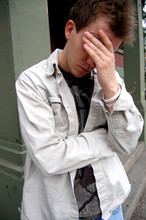

In [ ]:
img_name = 'img_test_1.jpg'
image = Image.open(img_name)
image

Extract the embeddings from original CLIP model

In [ ]:
# get visual embedding
inputs = processor(images=image, return_tensors="tf")
image_features = clip_model_tf.get_image_features(**inputs)
image_features = image_features.numpy()
image_features.shape

(1, 512)

**Call our trained CLIP-E crossentropy model** 😊😍😭😀😒😡

In [ ]:
model = CLIP_e_crossentropy()
model.load_weights('clip-e_25cat.hdf5')

**Inference**

Sentiment Classification: nervousness


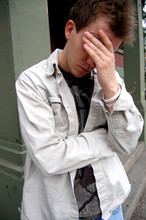

In [ ]:
preds = model.predict(image_features, verbose=0)
preds = np.squeeze(preds)
y = np.argmax(preds)

print('Sentiment Classification:', sentiment_labels[y])
image

It's also interesting to see the top-k predictions

In [ ]:
k = 5

preds_ordered = np.sort(preds)[::-1]
preds_ordered_index = np.argsort(preds)[::-1]
sentiment_labels_np = np.asarray(sentiment_labels)
top_k_preds = sentiment_labels_np[preds_ordered_index]

print('Top ', k, ' predictions')
for i in range(k):
  print(str(i+1)+':',top_k_preds[i])

Top  5  predictions
1: nervousness
2: sadness
3: shame
4: disappointment
5: neglect


# 4.2 Primary emotions: 6 categories


In [ ]:
sentiment_labels_6_cats = ['anger', 'fear', 'joy','love','sadness','surprise']

model_6_cats = CLIP_e_crossentropy(num_classes=6)
model_6_cats.load_weights('clip-e_6cat.hdf5')

preds = model_6_cats.predict(image_features, verbose=0)
preds = np.squeeze(preds)
y = np.argmax(preds)
print('Sentiment 6 categories Classification:', sentiment_labels_6_cats[y])

Sentiment 6 categories Classification: sadness


# 4.3 Binary emotions: Negative or Positive


In [ ]:
binary_sentiment_labels = ['negative', 'positive']

model_binary = CLIP_e_crossentropy(num_classes=1,activation='sigmoid')
model_binary.load_weights('clip-e_binary.hdf5')

preds = model_binary.predict(image_features, verbose=0)
preds = preds[0][0]
y = int(preds > 0.5)
print('Binary sentiment Classification:', binary_sentiment_labels[y])

Binary sentiment Classification: negative


# 4.4 Observing the hierarchical predictions

Binary sentiment Classification: positive
Sentiment 6 categories Classification: joy
Sentiment 25 categories Classification: relief


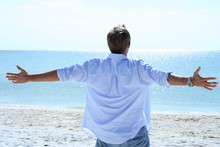

In [ ]:
img_name = 'img_test_2.jpg'
image = Image.open(img_name)
inputs = processor(images=image, return_tensors="tf")
image_features = clip_model_tf.get_image_features(**inputs)
image_features = image_features.numpy()

#binary preds
preds = model_binary.predict(image_features, verbose=0)
preds = preds[0][0]
y = int(preds > 0.5)
print('Binary sentiment Classification:', binary_sentiment_labels[y])

# 6 cats
preds = model_6_cats.predict(image_features, verbose=0)
y = np.argmax(np.squeeze(preds))
print('Sentiment 6 categories Classification:', sentiment_labels_6_cats[y])

#25 cats
preds = model.predict(image_features, verbose=0)
y = np.argmax(np.squeeze(preds))
print('Sentiment 25 categories Classification:', sentiment_labels[y])

image